In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as random

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDClassifier

from calibration_util import *
from kendall_errors import *
from convert_FA_IR import *
%matplotlib inline
%precision 3
import warnings
warnings.filterwarnings('ignore')

/home/caitlin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


FA*IR rankings apply post-processing methods to correct for unfairness 
according to criteria laid out in the paper.

Applies correction for a prefix of the ranking with length k
if k is larger than one of the candidate lists we have available, the ranking is filled up with
candidates from the other group, i.e. if all protected candidates already appear in the ranking
the left over positions are filled with non-protected

1. The "colorblind" ranking

2. "Baseline"
We just predict the rankings according to the original scores. This lets us analyze the statistical parity of the original list. there will be no errors for equalized odds or calibration.
3. "Feldman" 
this changes the scores assigned to items - instead of just rearranging the list. The process is :
        1. take a protected candidate x
        2. determine the percentile of that candidate within their group percentile(x)
        3. find a non-protected candidate y that has the same percentile(y) == percentile(x)
        4. assign the score of y to x
        5. goto 1
        
To analyze these scores we reset "y" to be the original scores

In [2]:
def plot_all(data, w, s): 
    plt.figure(figsize=(12, 3,))
    plt.subplot(131) # equivalent to: plt.subplot(2, 2, 1)
    
    e0,e1 = sliding_kendall_parity(data, window=w, step=s)
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.ylim([0,1])
    plt.title("Parity")

    plt.subplot(132) # equivalent to: plt.subplot(2, 2, 1)
    e0,e1 = sliding_kendall_cal2(data, window=w, step=s)
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.ylim([0,1])
    plt.title("Calibration")

    plt.subplot(133) # equivalent to: plt.subplot(2, 2, 1)
    e0,e1 = sliding_kendall_eq(data, window=w, step=s)
    plt.ylim([0,1])
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.title("Equality")
    plt.show()

In [3]:
def formatRank_german(df):
    tmp = pd.DataFrame()
    tmp['y']=df.sort_values('y_pred',ascending=False).index
    tmp['y_pred']=tmp.index
    tmp['g']=df.sort_values('y_pred',ascending=False).reset_index()['g']
    return tmp

In [4]:
german = getAllFA_IRData('data/processed/fa_ir_german_credit/GermanCreditAge25',formatRank_german)
german5 = getAllFA_IRData('data/processed/fa_ir_german_credit500/GermanCreditAge25',formatRank_german)
ger2 = getAllFA_IRData('data/processed/fa_ir_german_credit200/GermanCreditAge25',formatRank_german)
compas_gender = getAllFA_IRData('data/processed/fa_ir_compas_gender/CompasGender',formatRank_compas)
compas_race = getAllFA_IRData('data/processed/fa_ir_compas_race/CompasRace',formatRank_compas)

In [5]:
# german = plainFA_IRData('data/processed/fa_ir_german_credit/GermanCreditAge25')
# german5 = plainFA_IRData('data/processed/fa_ir_german_credit500/GermanCreditAge25')
# ger2 = plainFA_IRData('data/processed/fa_ir_german_credit200/GermanCreditAge25')
# compas_gender = plainFA_IRData('data/processed/fa_ir_compas_gender/CompasGender')
# compas_race = plainFA_IRData('data/processed/fa_ir_compas_race/CompasRace')

In [6]:
def plotFA_IRRanks(dict, w, s):
    print("\nWindow: "+str(w)+", Step: "+str(s))

    print("\nbaseline")
    print("# protected items", len(dict['base'][dict['base']['g']==True]))
    print("# protected items", len(dict['base'][dict['base']['g']==False]))
    plot_all(dict["base"], w, s)
    print(diagnose_k(dict["base"], w, s).round(2))

    print("\ncolorblind")
    print("# protected items", len(dict['cb'][dict['cb']['g']==True]))
    print("# protected items", len(dict['cb'][dict['cb']['g']==False]))
    plot_all(dict['cb'], w, s)
    print(diagnose_k(dict["cb"], w, s).round(2))
    print("\nfeldman")
    print("# protected items", len(dict['feld'][dict['feld']['g']==True]))
    print("# protected items", len(dict['feld'][dict['feld']['g']==False]))
    plot_all(dict['feld'], w, s)
    print(diagnose_k(dict["feld"], w, s).round(2))
    print("\nfair 1")
    print("# protected items", len(dict['fair1'][dict['fair1']['g']==True]))
    print("# protected items", len(dict['fair1'][dict['fair1']['g']==False]))
    plot_all(dict['fair1'], w, s)
    print(diagnose_k(dict["fair1"], w, s).round(2))
    print("\nfair 2")
    print("# protected items", len(dict['fair2'][dict['fair2']['g']==True]))
    print("# protected items", len(dict['fair2'][dict['fair2']['g']==False]))
    plot_all(dict['fair2'], w, s)
    print(diagnose_k(dict["fair2"], w, s))
    print("\nfair 5")
    print("# protected items", len(dict['fair5'][dict['fair5']['g']==True]))
    print("# protected items", len(dict['fair5'][dict['fair5']['g']==False]))
    plot_all(dict['fair5'], w, s)
    print(diagnose_k(dict["fair5"], w, s).round(2))
    print("\nfair 6")
    print("# protected items", len(dict['fair6'][dict['fair6']['g']==True]))
    print("# protected items", len(dict['fair6'][dict['fair6']['g']==False]))
    plot_all(dict['fair6'], w, s)
    print(diagnose_k(dict["fair6"], w, s).round(2))
    print("\nfair 7")
    print("# protected items", len(dict['fair7'][dict['fair7']['g']==True]))
    print("# protected items", len(dict['fair7'][dict['fair7']['g']==False]))
    plot_all(dict['fair7'], w, s)
    print(diagnose_k(dict["fair8"], w, s).round(2))
    print("\nfair 8")
    print("# protected items", len(dict['fair8'][dict['fair8']['g']==True]))
    print("# protected items", len(dict['fair8'][dict['fair8']['g']==False]))
    plot_all(dict['fair8'], w, s)
    print(diagnose_k(dict["fair8"], w, s).round(2))

In [7]:
def sliding_count_groups(df, window, step):
    df.sort_values('y_pred', ascending=False, inplace=True)
    err0=[]
    err1=[]
    start=0
    end=window
    while end<len(df):
        vals = df.iloc[range(start,end)]
        g = np.array(vals[['y_pred', 'g']])
        p = pairs(len(g)) - pairs(len(vals[vals['g']==1])) - pairs(len(vals[vals['g']==0]))
        print("Num g0:", len(vals[vals['g']==0]),"Num g1:", len(vals[vals['g']==1]), "Num mixed pairs:",p)
        start+=step
        end+=step
#     get end of rank is needed
    if(start > len(df)-window):
        vals = df.iloc[range(len(df)-window,len(df))]
        g = np.array(vals[['y_pred', 'g']])
        p = pairs(len(g)) - pairs(len(vals[vals['g']==1])) - pairs(len(vals[vals['g']==0]))
        print("Num g0:", len(vals[vals['g']==0]),"Num g1:", len(vals[vals['g']==0]), "Num mixed pairs:",p)

In [8]:
def sliding_plot_groups(df, window, step):
    df.sort_values('y_pred', ascending=False, inplace=True)
    df['g'] *=1
    err0=[]
    err1=[]
    start=0
    end=window
    while end<len(df):
        vals = df.iloc[range(start,end)]
        cmap = plt.cm.rainbow
        plt.rcParams['figure.figsize'] = (20, 4)
        fig, ax = plt.subplots()
        ax.bar(range(len(vals)), vals['y_pred'], 0.5, color=cmap((vals['g'])))
        ax.set_xlim([0,len(vals)])
        plt.show()
#     get end of rank is needed
#     if(start > len(df)-window):
#         vals = df.iloc[range(len(df)-window,len(df))]
#         g = np.array(vals[['y_pred', 'g']])
#         p = pairs(len(g)) - pairs(len(vals[vals['g']==1])) - pairs(len(vals[vals['g']==0]))
#         print("Num g0:", len(vals[vals['g']==0]),"Num g1:", len(vals[vals['g']==0]), "Num mixed pairs:",p)

In [10]:
def append_all(feld):
    g_all = pd.read_pickle('data/processed/fa_ir_german_credit/GermanCreditAge25ColorblindRanking.pickle')
    g_all = g_all.sort_values('y', ascending=False)[['y','g']]
    g_all['y_pred'] = g_all['y']
    # print(g_all)
    n0 = len(feld[feld['g']==0])
    n1 = len(feld[feld['g']==1])
    print(n0)
    print(n1)
    g0 = g_all[g_all['g'] == 0].reindex()
    g1 = g_all[g_all['g']==1].reindex()
    g0.drop(g0.index[range(n0)], inplace=True)
    g1.drop(g1.index[range(n1)], inplace=True)
    feld_all = feld.append([g0, g1])
    return feld_all.sort_values('y')

In [12]:
def plot_score(data):
    df = data.copy()
    df.sort_values('y_pred', ascending=False, inplace=True)
    cmap = plt.cm.RdGy
    plt.rcParams['figure.figsize'] = (20, 4)
    df['g'] = 1 - df['g']
    df['g'] *=200
#     print(df)
    fig, ax = plt.subplots()
    ax.bar(range(len(df)), df['y'], 0.75, color=cmap((df['g'])))
    ax.set_xlim([0,len(df)])
    plt.show()

In [13]:
feld = pd.read_pickle('data/processed/fa_ir_german_credit200/GermanCreditAge25FeldmanRanking.pickle')
cb = pd.read_pickle('data/processed/fa_ir_german_credit200/GermanCreditAge25ColorblindRanking.pickle')
base = cb.copy()
base['y_pred'] = base['y']
f2 = pd.read_pickle('data/processed/fa_ir_german_credit200/GermanCreditAge25FairRanking02PercentProtected.pickle')
f4 = pd.read_pickle('data/processed/fa_ir_german_credit200/GermanCreditAge25FairRanking04PercentProtected.pickle')
f6 = pd.read_pickle('data/processed/fa_ir_german_credit200/GermanCreditAge25FairRanking06PercentProtected.pickle')
f8 = pd.read_pickle('data/processed/fa_ir_german_credit200/GermanCreditAge25FairRanking08PercentProtected.pickle')


In [23]:
def plot_rank(data):
    df = data.copy()
#     df.sort_values('y_pred', ascending=False, inplace=True)
    cmap = plt.cm.RdGy
    plt.rcParams['figure.figsize'] = (20, 4)
    df['g'] = 1 - df['g']
    df['g'] *=200
#     print(df)
    fig, ax = plt.subplots()
#     ax.bar(range(len(df)), df.sort_values('y', ascending=False)['y'], 0.75, color=cmap((df['g'])))
    ax.bar(df['y_pred'].rank(ascending=False, method='first'), df['y'], 0.75, color=cmap((df['g'])))
    ax.set_xlim([0,len(df)])
    plt.show()

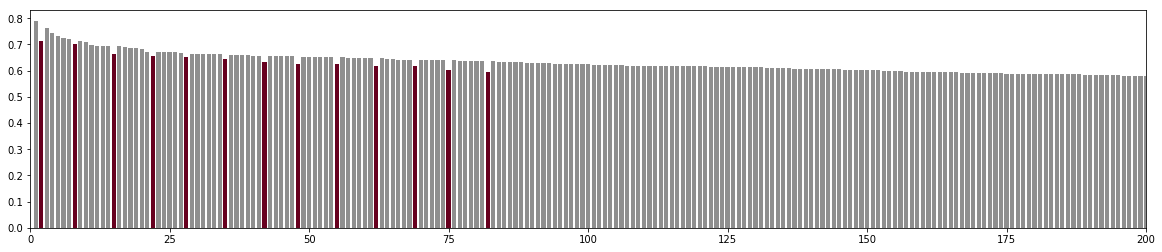

In [24]:
plot_rank(cb)

In [17]:
ger2['cb'].head()

,y,y_pred,g
0,0,0,False
1,7,1,True
2,1,2,False
3,2,3,False
4,3,4,False


In [14]:
# print("Original Ranking")
# plot_rank(append_all(base))
# print("Feldman")
# plot_rank(append_all(feld))
# print("colorblind")
# plot_rank(append_all(cb))
# print("Fair 20%")
# plot_rank(append_all(f2))
# print("Fair 40%")
# plot_rank(append_all(f4))
# print("Fair 40%")
# plot_rank(append_all(f4))
# print("Fair 40%")
# plot_rank(append_all(f4))

Original Ranking


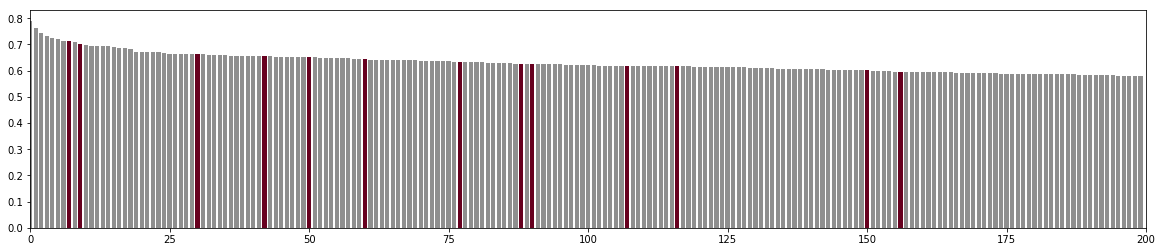

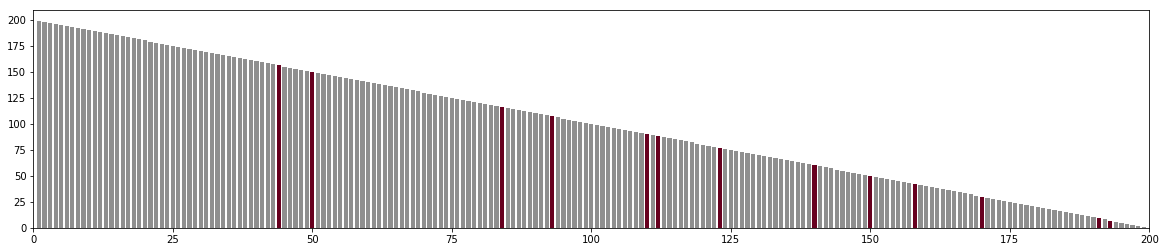

Feldman


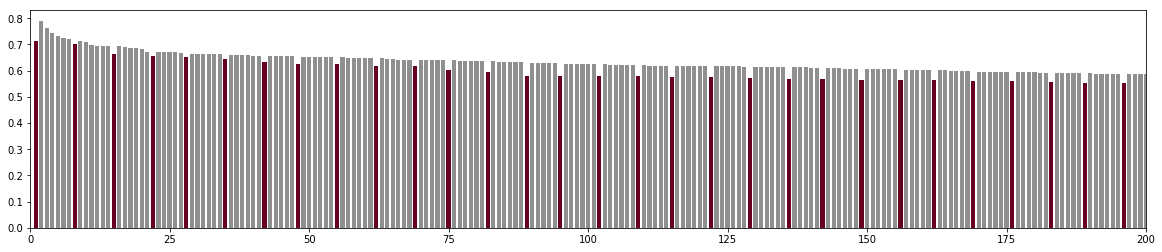

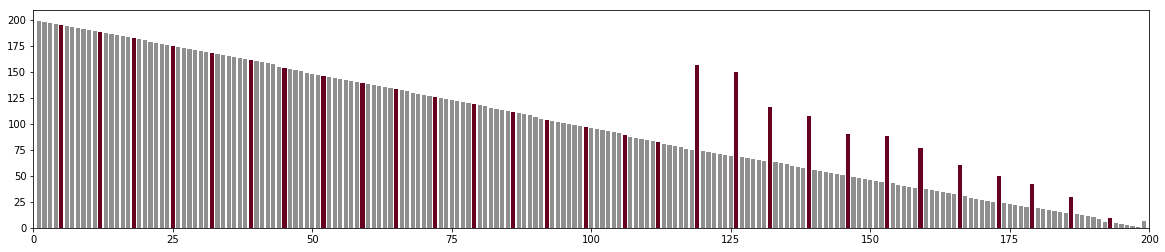

colorblind


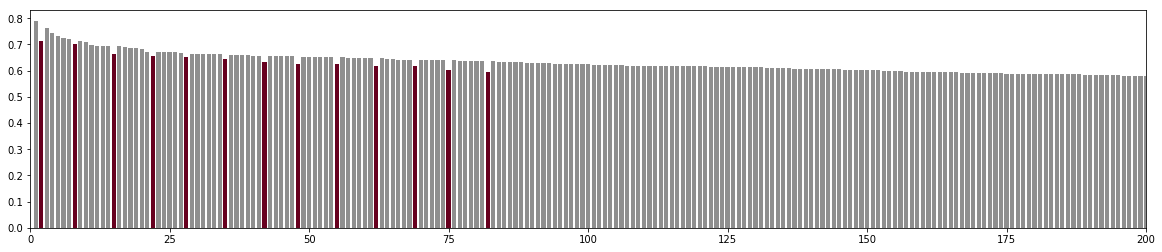

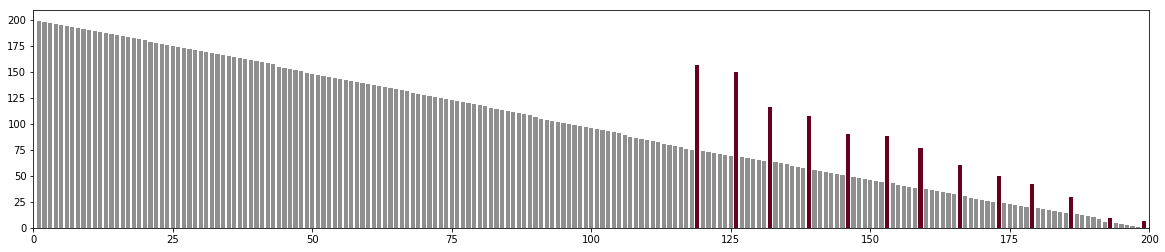

Fair 20%


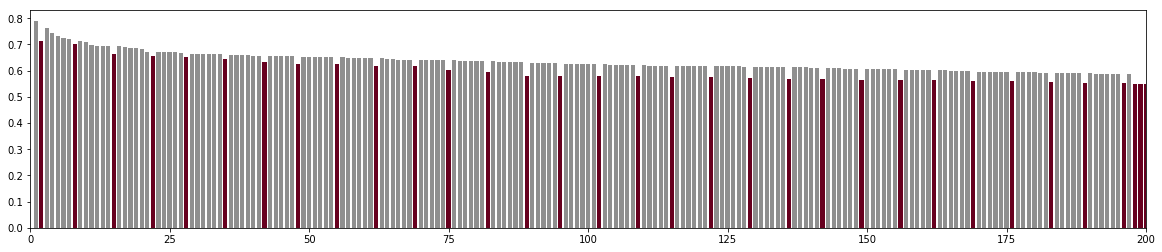

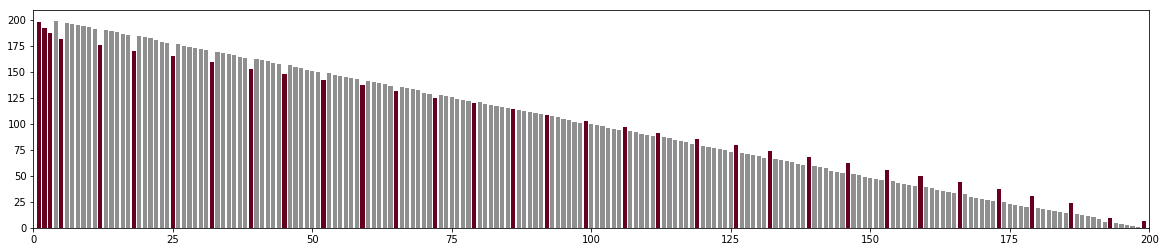

Fair 40%


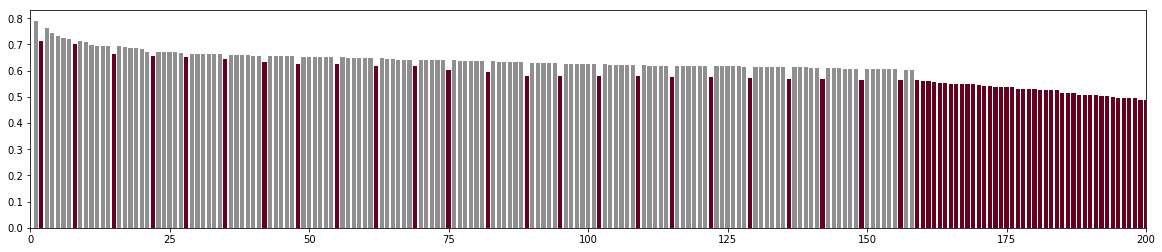

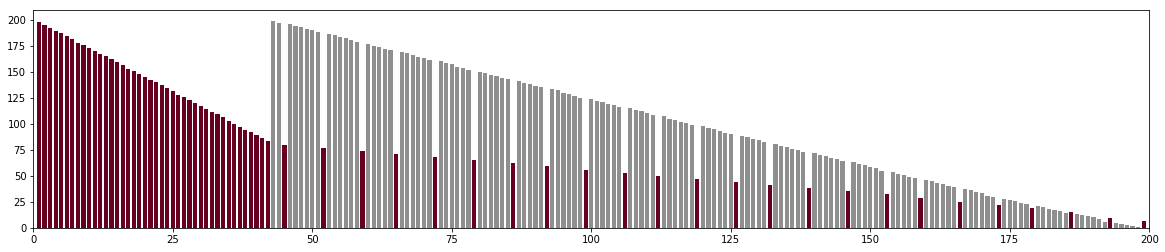

Fair 60%


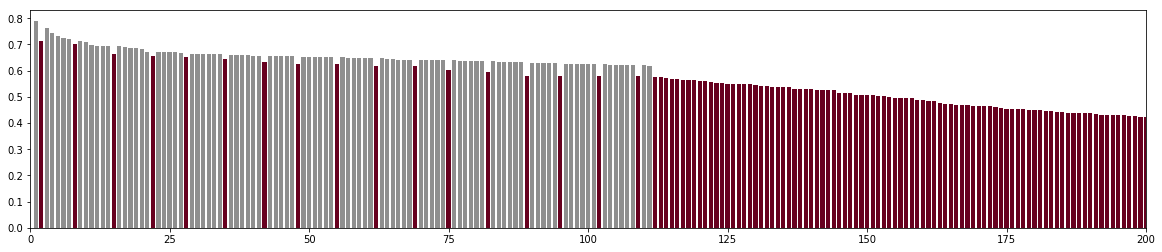

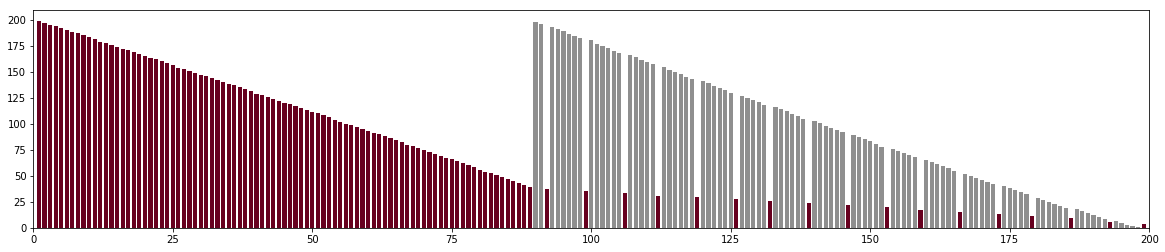

Fair 80%


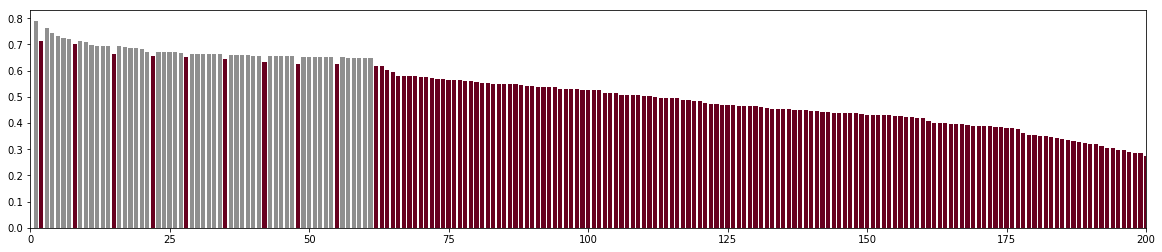

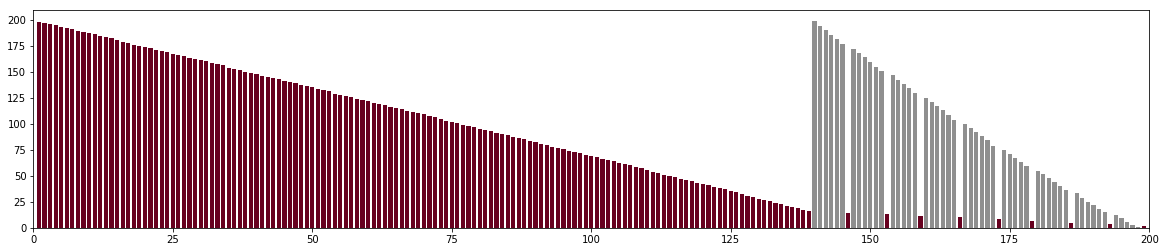

In [25]:
print("Original Ranking")
plot_score(base)
plot_rank(ger2['base'])
print("Feldman")
plot_rank(feld)
plot_rank(ger2['feld'])
print("colorblind")
plot_rank(cb)
plot_rank(ger2['cb'])
print("Fair 20%")
plot_rank(f2)
plot_rank(ger2['fair2'])
print("Fair 40%")
plot_rank(f4)
plot_rank(ger2['fair4'])
print("Fair 60%")
plot_rank(f6)
plot_rank(ger2['fair6'])
print("Fair 80%")
plot_rank(f8)
plot_rank(ger2['fair8'])

In [17]:
def plotFA_IRRanks(dict, w, s):
    print("\nWindow: "+str(w)+", Step: "+str(s))

    print("\nbaseline")
    print("# protected items", len(dict['base'][dict['base']['g']==True]))
    print("# protected items", len(dict['base'][dict['base']['g']==False]))
    plot_all(dict["base"], w, s)
#     print(diagnose_k(dict["base"], w, s).round(2))
    plot_rank(dict["base"])
    print("\ncolorblind")
    print("# protected items", len(dict['cb'][dict['cb']['g']==True]))
    print("# protected items", len(dict['cb'][dict['cb']['g']==False]))
    plot_all(dict['cb'], w, s)
#     print(diagnose_k(dict["cb"], w, s).round(2))
    plot_rank(dict["cb"])
    print("\nfeldman")
    print("# protected items", len(dict['feld'][dict['feld']['g']==True]))
    print("# protected items", len(dict['feld'][dict['feld']['g']==False]))
    plot_all(dict['feld'], w, s)
#     print(diagnose_k(dict["feld"], w, s).round(2))
    plot_rank(dict["feld"])
    print("\nfair 1")
    print("# protected items", len(dict['fair1'][dict['fair1']['g']==True]))
    print("# protected items", len(dict['fair1'][dict['fair1']['g']==False]))
    plot_all(dict['fair1'], w, s)
#     print(diagnose_k(dict["fair1"], w, s).round(2))
    plot_rank(dict["fair1"])
    print("\nfair 2")
    print("# protected items", len(dict['fair2'][dict['fair2']['g']==True]))
    print("# protected items", len(dict['fair2'][dict['fair2']['g']==False]))
    plot_all(dict['fair2'], w, s)
#     print(diagnose_k(dict["fair2"], w, s))
    plot_rank(dict["fair2"])
    print("\nfair 4")
    print("# protected items", len(dict['fair4'][dict['fair5']['g']==True]))
    print("# protected items", len(dict['fair4'][dict['fair5']['g']==False]))
    plot_all(dict['fair4'], w, s)
#     print(diagnose_k(dict["fair4"], w, s).round(2))
    plot_rank(dict["fair4"])
    print("\nfair 6")
    print("# protected items", len(dict['fair6'][dict['fair6']['g']==True]))
    print("# protected items", len(dict['fair6'][dict['fair6']['g']==False]))
    plot_all(dict['fair6'], w, s)
#     print(diagnose_k(dict["fair6"], w, s).round(2))
    plot_rank(dict["fair6"])
    print("\nfair 8")
    print("# protected items", len(dict['fair8'][dict['fair8']['g']==True]))
    print("# protected items", len(dict['fair8'][dict['fair8']['g']==False]))
    plot_all(dict['fair8'], w, s)
#     print(diagnose_k(dict["fair8"], w, s).round(2))
    plot_rank(dict["fair8"])

If parity sequence contains windows that have only one group, the trends will not be inverse of each other.
Current version drops those measurements to get a more interpretable result.

If there is a strong tren for one group

German Credit k=200

Window: 100, Step: 10

baseline
# protected items 13
# protected items 187


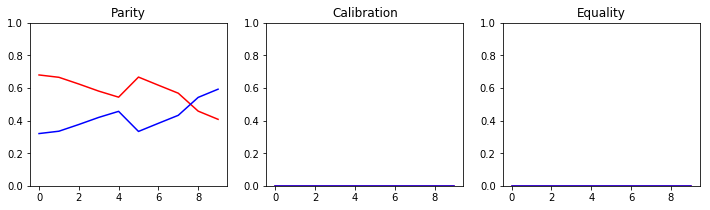

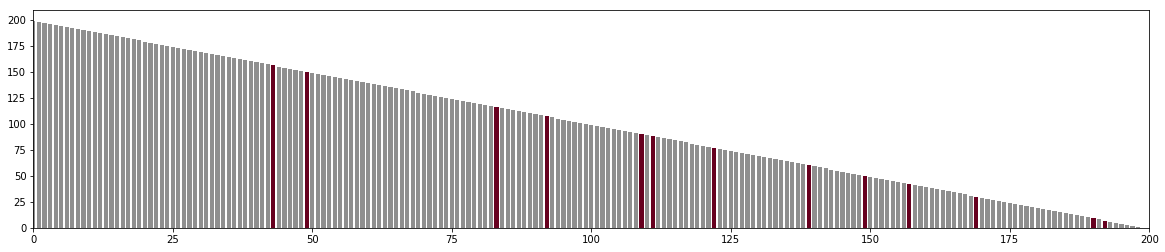


colorblind
# protected items 13
# protected items 187


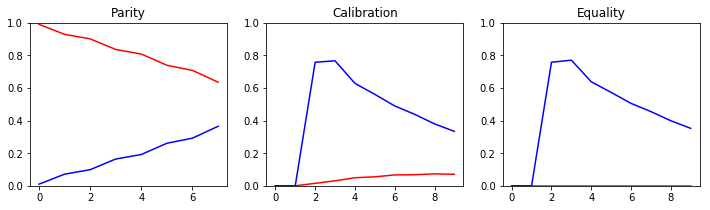

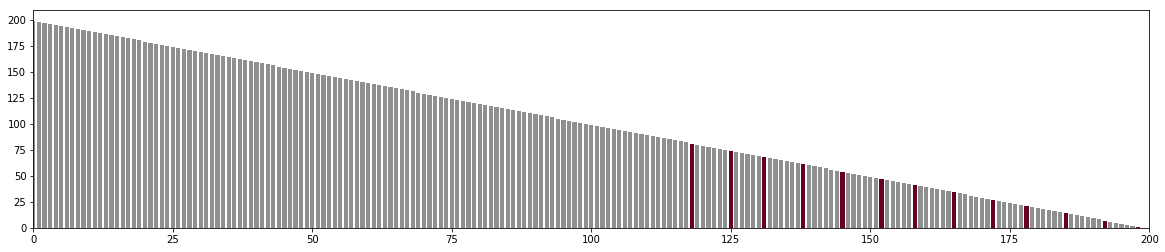


feldman
# protected items 30
# protected items 170


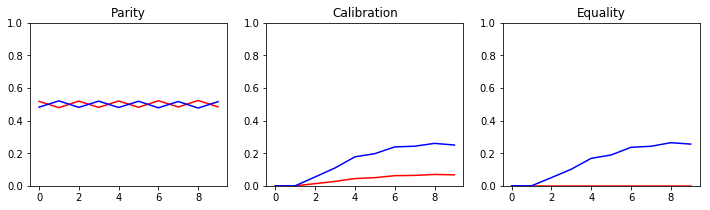

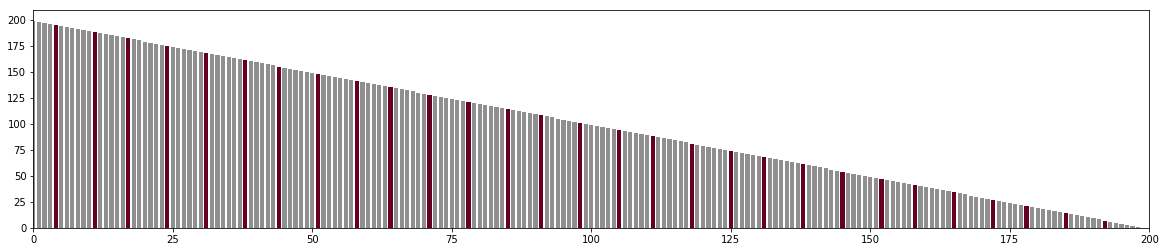


fair 1
# protected items 15
# protected items 185


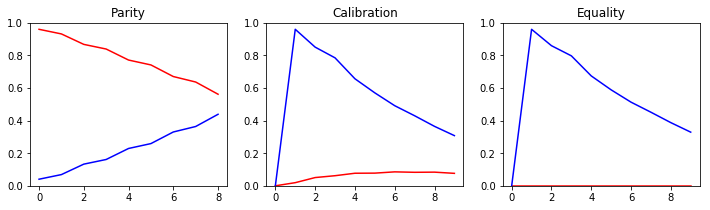

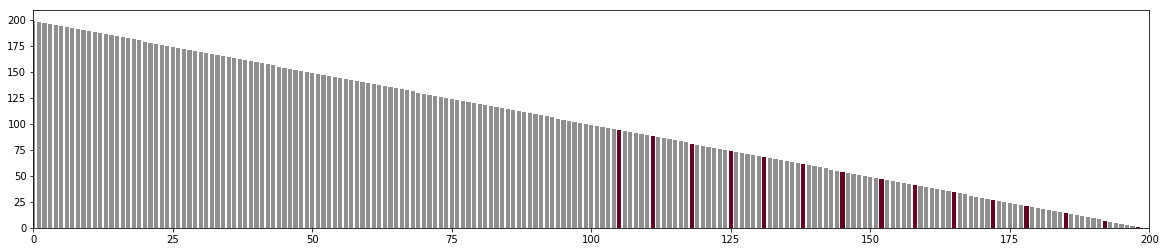


fair 2
# protected items 33
# protected items 167


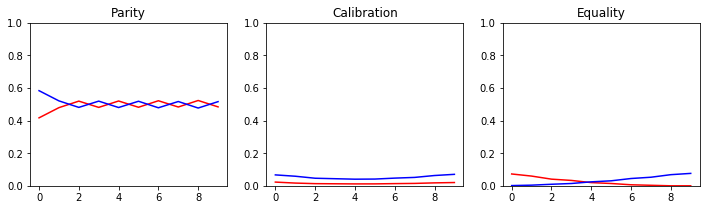

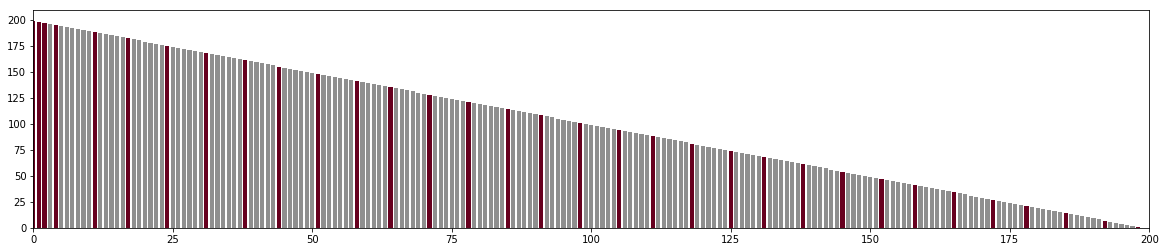


fair 4
# protected items 86
# protected items 114


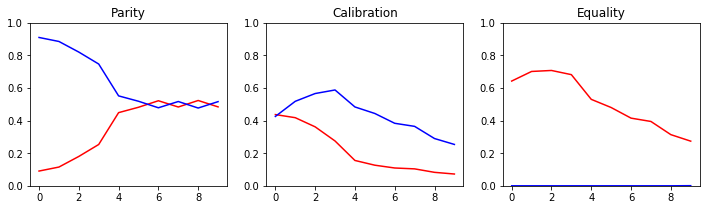

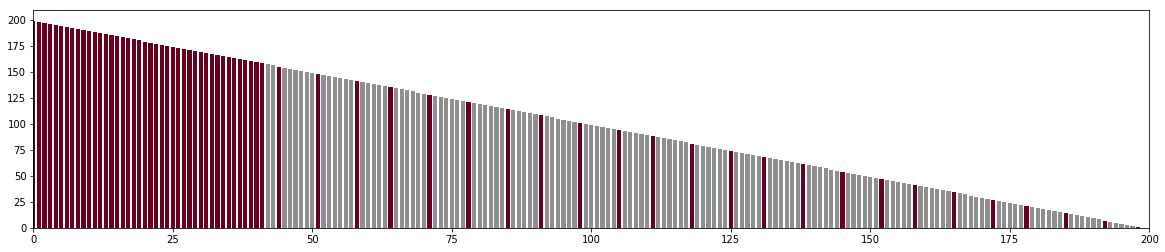


fair 6
# protected items 106
# protected items 94


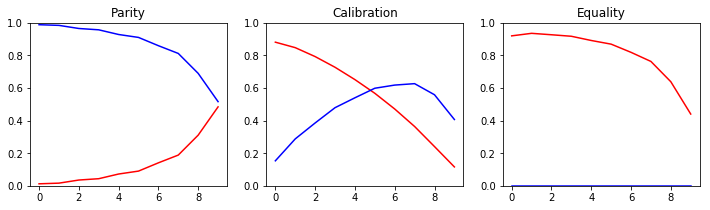

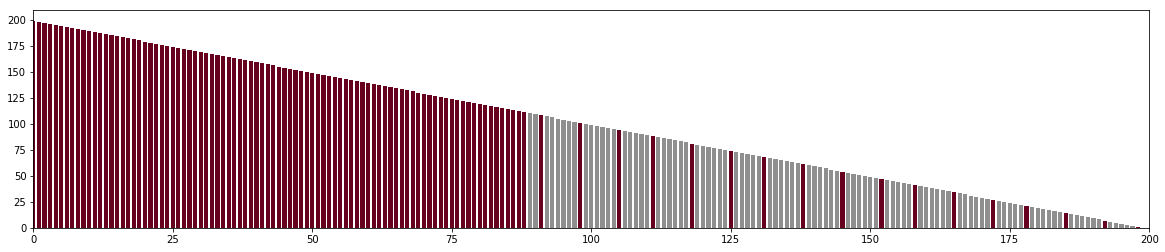


fair 8
# protected items 148
# protected items 52


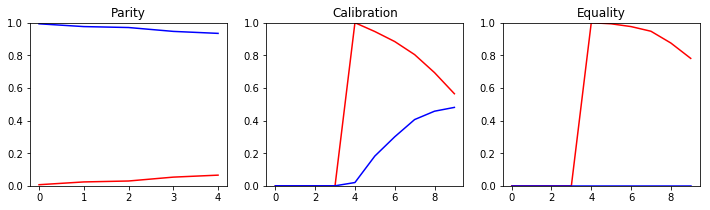

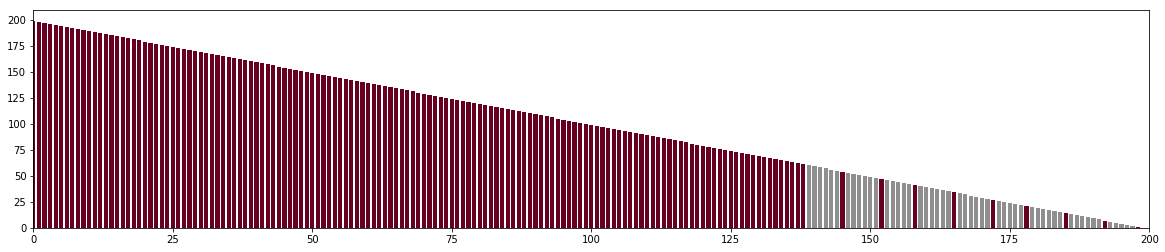

In [18]:
print("German Credit k=200")
plotFA_IRRanks(ger2, 100, 10)

In [19]:
def scale(data, col):
    data[col] = (data[col]-data[col].min()) / (data[col].max() - data[col].min())

In [29]:
# sliding_kendall_parity(german5['fair5'], window=100, step=10)[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.990,
 0.952,
 0.924,
 0.894,
 0.841,
 0.800,
 0.755,
 0.682,
 0.619,
 0.545,
 0.499,
 0.491,
 0.504,
 0.496,
 0.489,
 0.503,
 0.497,
 0.491,
 0.485,
 0.500,
 0.496,
 0.491,
 0.507,
 0.484,
 0.501,
 0.499,
 0.477,
 0.497,
 0.478,
 0.479,
 0.503,
 0.468,
 0.476]

In [48]:
# sliding_kendall_parity(german5['fair5'], window=100, step=10)[1]

Ther are only 149 items in the protected class (German Credit dataset)

So for a prefix of k=500: 

20% representation requires 100 items
30% requires 150
50% requires 250 items 
75% requires 375

This may be why we see the strange patterns in the parity plots for > 30% representation

German Credit k=500

Window: 350, Step: 10

baseline
# protected items 64
# protected items 436


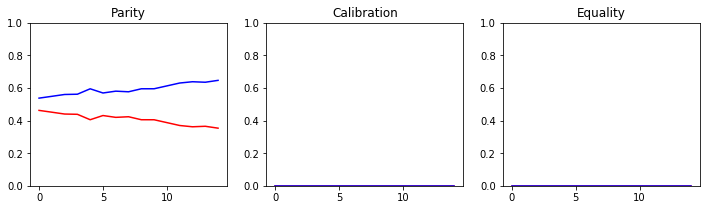

        parity  cal   eq
trend0   -0.11  0.0  0.0
trend1    0.11  0.0  0.0
dist      0.18  0.0  0.0

colorblind
# protected items 64
# protected items 436


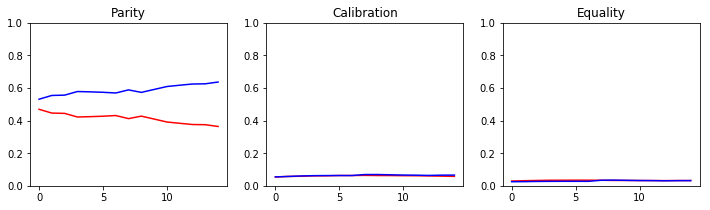

        parity   cal    eq
trend0   -0.10  0.00  0.00
trend1    0.10  0.01  0.01
dist      0.17  0.00  0.00

feldman
# protected items 75
# protected items 425


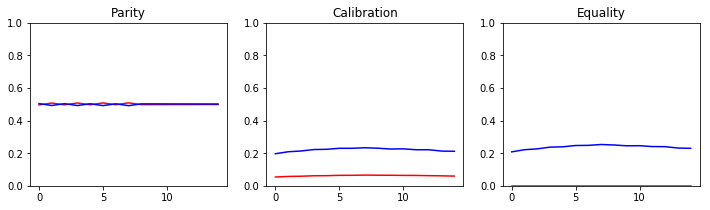

        parity   cal    eq
trend0   -0.00  0.01  0.00
trend1    0.00  0.01  0.02
dist      0.01  0.16  0.24

fair 1
# protected items 64
# protected items 436


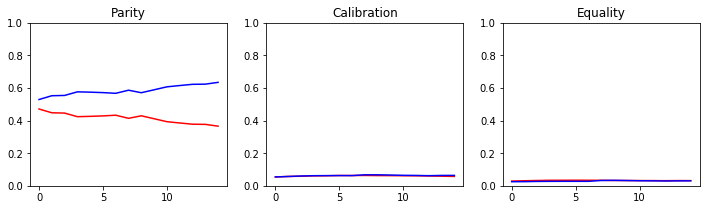

        parity   cal    eq
trend0   -0.10  0.00  0.00
trend1    0.10  0.01  0.01
dist      0.17  0.00  0.00

fair 2
# protected items 89
# protected items 411


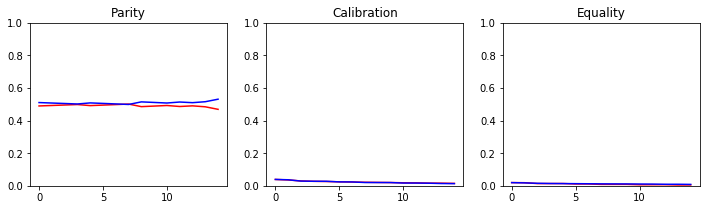

        parity   cal    eq
trend0   -0.02 -0.02 -0.01
trend1    0.02 -0.03 -0.01
dist      0.02  0.00  0.00

fair 3
# protected items 130
# protected items 370


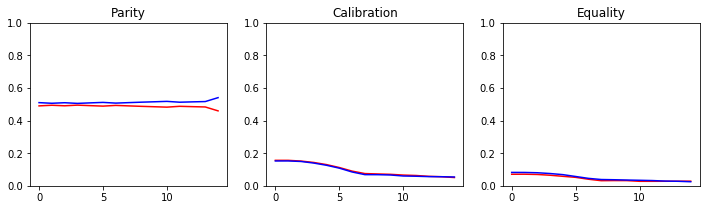

        parity   cal    eq
trend0   -0.02 -0.13 -0.06
trend1    0.02 -0.13 -0.07
dist      0.03  0.00  0.01

fair 4
# protected items 149
# protected items 351


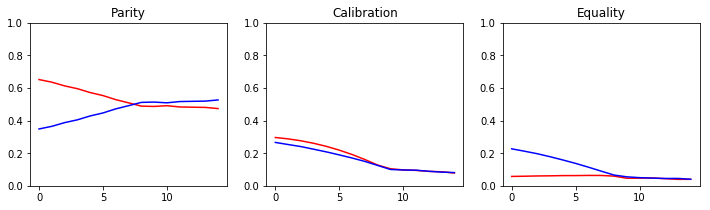

        parity   cal    eq
trend0    -0.2 -0.27 -0.02
trend1     0.2 -0.22 -0.22
dist       0.1  0.02  0.06


In [19]:
print("German Credit k=500")
plotFA_IRRanks(german5, w=350, s=10)

Compas Gender k=ALL

Window: 100, Step: 10

baseline
# protected items 1328
# protected items 5561


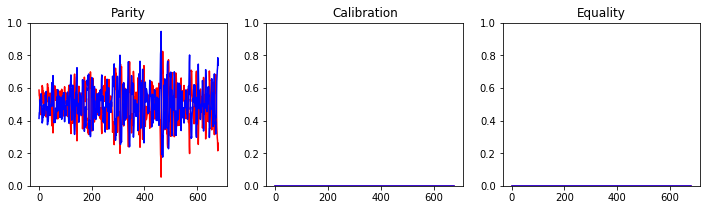

        parity  cal   eq
trend0   -0.02  0.0  0.0
trend1    0.02  0.0  0.0
dist      0.17  0.0  0.0

colorblind
# protected items 1328
# protected items 5561


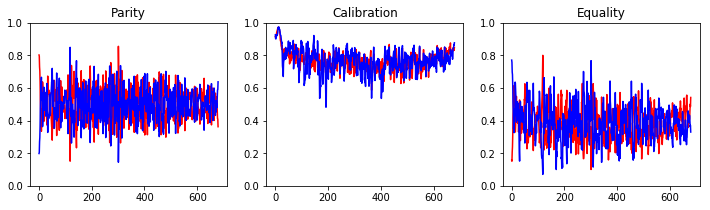

KeyboardInterrupt: 

In [20]:
print("Compas Gender k=ALL")
plotFA_IRRanks(compas_gender, w=100, s=10)

compas_race k=ALL

Window: 100, Step: 10

baseline
# protected items 3528
# protected items 3361


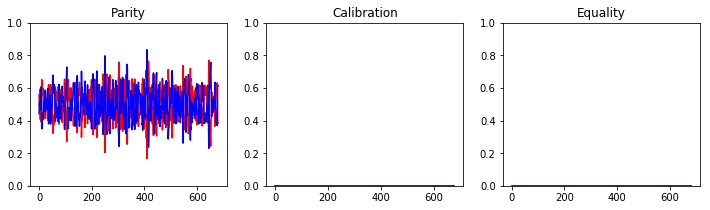

        parity  cal   eq
trend0   -0.00  0.0  0.0
trend1    0.00  0.0  0.0
dist      0.15  0.0  0.0

colorblind
# protected items 3528
# protected items 3361


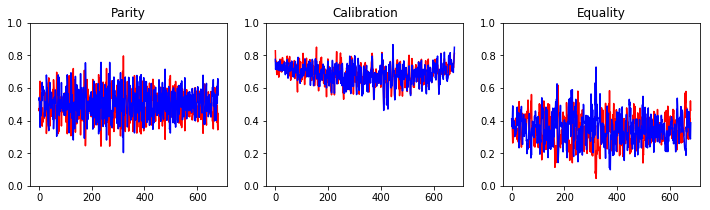

        parity   cal    eq
trend0   -0.01 -0.02  0.00
trend1    0.01 -0.01 -0.02
dist      0.13  0.03  0.12

feldman
# protected items 3528
# protected items 3361


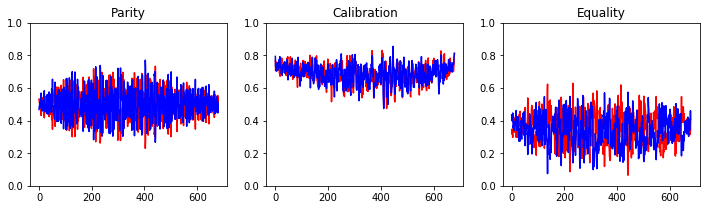

        parity   cal    eq
trend0    0.00 -0.02 -0.02
trend1   -0.00 -0.02 -0.00
dist      0.13  0.04  0.13

fair 1
# protected items 3528
# protected items 3361


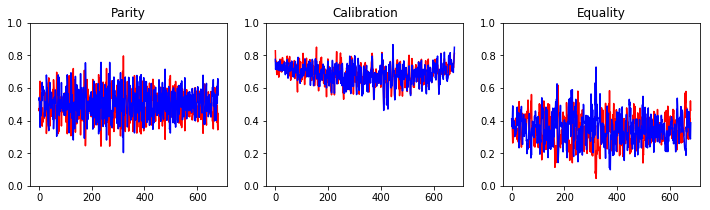

        parity   cal    eq
trend0   -0.01 -0.02  0.00
trend1    0.01 -0.01 -0.02
dist      0.13  0.03  0.12

fair 2
# protected items 3528
# protected items 3361


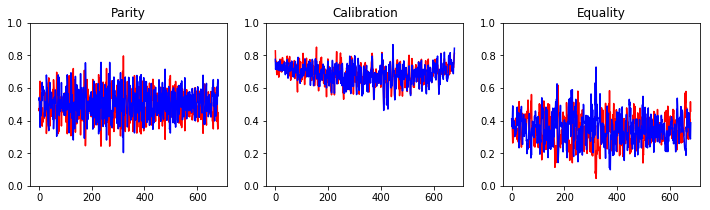

        parity   cal    eq
trend0   -0.01 -0.02  0.00
trend1    0.01 -0.01 -0.02
dist      0.13  0.03  0.12

fair 3
# protected items 3528
# protected items 3361


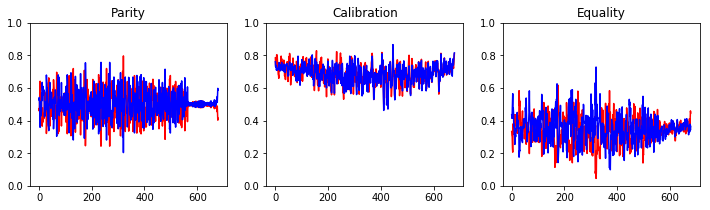

        parity   cal    eq
trend0   -0.00 -0.02  0.01
trend1    0.00 -0.02 -0.03
dist      0.12  0.03  0.11

fair 4
# protected items 3528
# protected items 3361


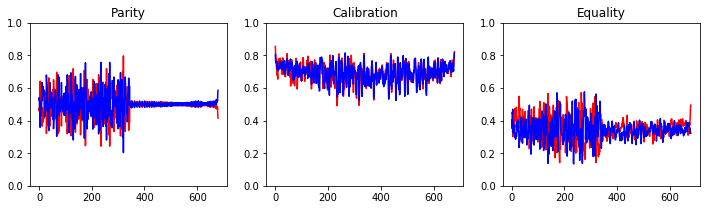

        parity   cal    eq
trend0    0.00 -0.01 -0.01
trend1   -0.00 -0.01 -0.00
dist      0.08  0.02  0.08


In [17]:
print("compas_race k=ALL")
plotFA_IRRanks(compas_race, w=100, s=10)